This notebook highlights the install and usage of the PII-Codex package to identify and determine severity of PII tokens in text.

Project URL: https://github.com/EdyVision/pii-codex

In [1]:
# The pii-codex module depends on Python 3.9 minimum (up to 3.10.x)
!python3 --version

Python 3.10.12


In [2]:
!pip install pii-codex
!pip install pii-codex[detections]

In [3]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
from pii_codex.services.analysis_service import PIIAnalysisService
import pandas as pd

pii_analysis_service = PIIAnalysisService()

# Run the detection and assessments in one shot with the PIIAnalysisService
analysis_results = pii_analysis_service.analyze_collection(
    texts=[
       "{'name': 'Susan Campos', 'email': 'rick74@example.org', 'phone_number': '001-593-352-1127x68325', 'garbage_data': None, 'empty_field_1': '', 'empty_field_2': '', 'random_place_name': None}"
        ],
    collection_type="population",
    collection_name="PII Collection 1"
)

print("Collection Risk Score: ", analysis_results.risk_score_mean)
analysis_results.detected_pii_type_frequencies

Collection Risk Score:  2.6666666666666665


Counter({'EMAIL_ADDRESS': 1, 'PERSON': 1, 'URL': 1})

In [5]:

analysis_results = pii_analysis_service.analyze_collection(
    data=pd.DataFrame.from_dict({
        "text": [
              "{'name': 'Susan Campos', 'email': 'rick74@example.org', 'phone_number': '001-593-352-1127x68325', 'garbage_data': None, 'empty_field_1': '', 'empty_field_2': '', 'random_place_name': None}"
        ],
        "metadata": [
            {"location": True, "url": False, "screen_name": True},

        ]
    }),
    collection_type="population",
    collection_name="PII Collection 1"
)

results = analysis_results.to_dict()
results

{'collection_name': 'PII Collection 1',
 'collection_type': 'POPULATION',
 'analyses': [{'analysis': [{'pii_type_detected': 'EMAIL_ADDRESS',
     'risk_level': 3,
     'risk_level_definition': 'Identifiable',
     'cluster_membership_type': 'Personal Preferences',
     'hipaa_category': 'Protected Health Information',
     'dhs_category': 'Stand Alone PII',
     'nist_category': 'Directly PII',
     'entity_type': 'EMAIL_ADDRESS',
     'score': 1.0,
     'start': 35,
     'end': 53},
    {'pii_type_detected': 'PERSON',
     'risk_level': 3,
     'risk_level_definition': 'Identifiable',
     'cluster_membership_type': 'Financial Information',
     'hipaa_category': 'Protected Health Information',
     'dhs_category': 'Linkable',
     'nist_category': 'Directly PII',
     'entity_type': 'PERSON',
     'score': 0.85,
     'start': 10,
     'end': 23},
    {'pii_type_detected': 'URL',
     'risk_level': 2,
     'risk_level_definition': 'Semi-Identifiable',
     'cluster_membership_type': '

For those in need to store off the data but do not wish to have the raw text stored, the library leverages Microsoft Presidio to sanitize the input text, redacting the detected items from the original analysis. The redactions are entirely configurable within the presidio_analysis.py file.

In [6]:
sanitized_texts = [result["sanitized_text"] for result in results["analyses"]]
sanitized_texts

["{'name': '<REDACTED>, 'email': '<REDACTED>', 'phone_number': '001-593-352-1127x68325', 'garbage_data': None, 'empty_field_1': '', 'empty_field_2': '', 'random_place_name': None}"]

In [7]:
analyses = results["analyses"]
analyses_df = pd.DataFrame(
    analyses
)
analyses_df["collection_name"] = results["collection_name"]
analyses_df

,analysis,index,risk_score_mean,sanitized_text,collection_name
0,"[{'pii_type_detected': 'EMAIL_ADDRESS', 'risk_...",0,2.6,"{'name': '<REDACTED>, 'email': '<REDACTED>', '...",PII Collection 1


In [8]:
data = results.copy()
del data['analyses']

analyses_collection_df = pd.DataFrame(
    [data]
)

analyses_collection_df.T

,0
collection_name,PII Collection 1
collection_type,POPULATION
detection_count,5
risk_scores,[2.6]
risk_score_mean,2.6
risk_score_mode,2.6
risk_score_median,2.6
risk_score_standard_deviation,0.0
risk_score_variance,0.0
detected_pii_types,"{PERSON, LOCATION, URL, EMAIL_ADDRESS, SCREEN_..."


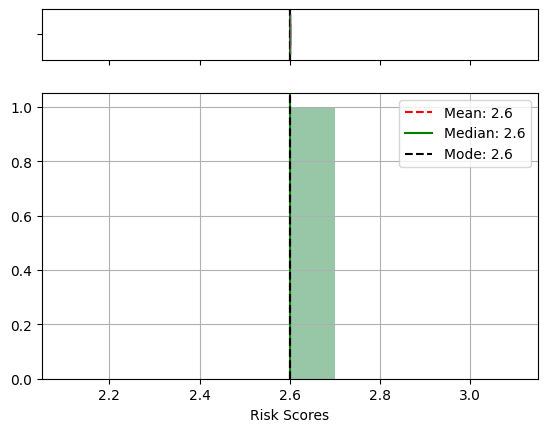

In [9]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_palette(sns.color_palette("crest"))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

mean=analyses_collection_df['risk_score_mean'].item()
median=analyses_collection_df['risk_score_median'].item()
mode=analyses_collection_df['risk_score_mode'].item()

sns.boxplot(data=analyses_df, x="risk_score_mean", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='green', linestyle='-')
ax_box.axvline(mode, color='black', linestyle='--')

ax_hist.hist(analyses_collection_df["risk_scores"], alpha = 0.8)
ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean: {round(mean, 2)}")
ax_hist.axvline(median, color='green', linestyle='-', label=f"Median: {round(median, 2)}")
ax_hist.axvline(mode, color='black', linestyle='--', label=f"Mode: {mode}")

ax_hist.set(xlabel='Risk Scores')
ax_hist.legend()

ax_box.set(xlabel='')
plt.grid()
plt.show()

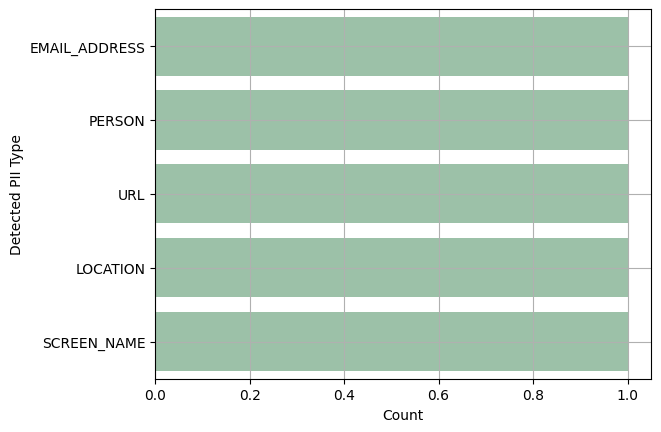

In [10]:
# Plot the detected types
detected_types = []
for detection in analyses_collection_df["detected_pii_type_frequencies"].item():
    detected_types.append({
        "Collection": analyses_collection_df["collection_name"].item(),
        "Detected PII Type": detection,
        "Count": analyses_collection_df["detected_pii_type_frequencies"].item()[detection]
    })

detected_types_df = pd.DataFrame(detected_types)

sns.barplot(data=detected_types_df, y="Detected PII Type", x="Count", alpha = 0.8)
plt.grid()